Initial Dependencies

In [ ]:
!git clone https://github.com/jantic/DeOldify.git /content/DeOldify
%cd /content/DeOldify
!pip install -r requirements-colab.txt

In [ ]:
!mkdir models
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth


In [ ]:
!pip install flask flask-cors pyngrok


In [ ]:
!sed -i 's/state = torch.load(tmp_file)/state = torch.load(tmp_file, weights_only=False)/g' fastai/basic_train.py

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 --force-reinstall

In [ ]:
!pip install numpy==1.24.4 --force-reinstall

## Deoldify Setup

In [16]:
%cd /content/DeOldify
from deoldify import device
from deoldify.device_id import DeviceId
device.set(device=DeviceId.GPU0)
from deoldify.visualize import get_image_colorizer
colorizer = get_image_colorizer(artistic=True)

/content/DeOldify


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


NumExpr defaulting to 2 threads.


/content/DeOldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/content/DeOldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  wa

## TEST-1

PosixPath('result_images/cyc.jpg')

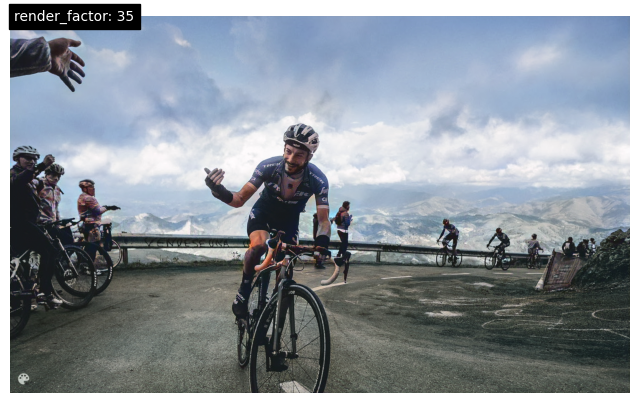

In [17]:
colorizer.plot_transformed_image(
    '/content/sample_data/cyc.jpg',
    render_factor=35,
    display_render_factor=True,
    figsize=(8,8)
)


## TEST-2 (Side by Side comaprison)

Saving f1.webp to f1.webp


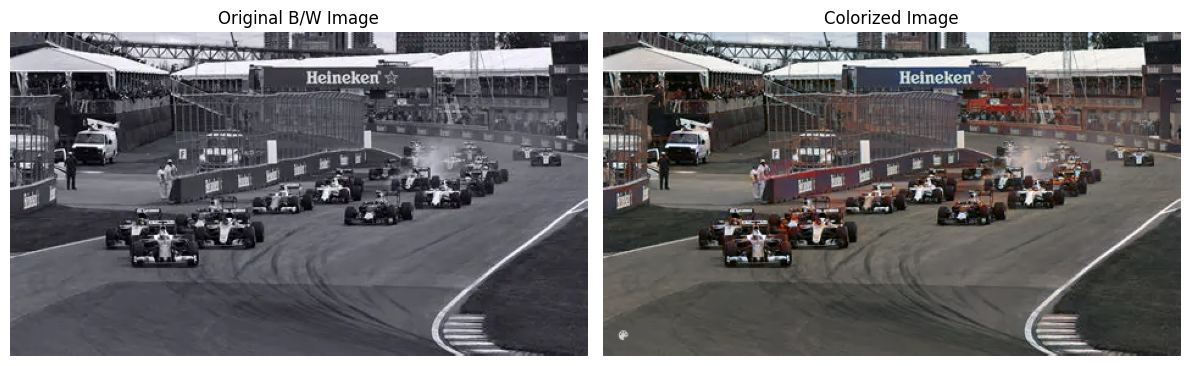

In [19]:
from IPython.display import display
from deoldify.visualize import *
from pathlib import Path
from fastai.vision import open_image
import matplotlib.pyplot as plt
import torch
from google.colab import files
import shutil

uploaded = files.upload()
input_image_path = Path(list(uploaded.keys())[0])
result_dir = Path('./result_images')
result_dir.mkdir(parents=True, exist_ok=True)

colorized_image = colorizer.get_transformed_image(
    path=input_image_path,
    render_factor=35
)

original_image = open_image(input_image_path).data.permute(1, 2, 0).cpu()
colorized_image = colorized_image.resize(original_image.shape[1::-1])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original B/W Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Colorized Image")
plt.imshow(colorized_image)
plt.axis("off")

plt.tight_layout()
plt.show()

## Simple web app

In [8]:
!mkdir -p /content/Web/templates


In [11]:
import os
os.makedirs("static", exist_ok=True)


In [12]:
# this cell wil create a htmlfile for web-page layout
%%writefile /content/Web/templates/index.html
<!doctype html>
<html lang="en">
<head>
  <title>DeOldify Colorizer</title>
  <style>
    body {
      background-color: #1e1e1e;
      color: #f5f5f5;
      font-family: Arial, sans-serif;
      text-align: center;
      padding: 40px;
    }
    .container {
      background: #2b2b2b;
      padding: 30px;
      border-radius: 12px;
      box-shadow: 0 0 15px rgba(0,0,0,0.5);
      max-width: 800px;
      margin: auto;
    }
    input[type="file"] {
      padding: 10px;
      background: #333;
      color: white;
      border: none;
      margin-bottom: 10px;
    }
    input[type="submit"] {
      background: #00c8ff;
      border: none;
      padding: 10px 20px;
      font-weight: bold;
      border-radius: 8px;
      cursor: pointer;
    }
    .image-row {
      display: flex;
      justify-content: space-around;
      margin-top: 20px;
    }
    .image-col {
      flex: 1;
      margin: 0 10px;
    }
    .image-col img {
      width: 100%;
      border-radius: 8px;
    }
    a {
      color: #00c8ff;
    }
  </style>
</head>
<body>
  <div class="container">
    <h2>Upload a B/W Image to Colorize 🌈</h2>
    <form method="post" enctype="multipart/form-data">
      <input type="file" name="image" required><br>
      <input type="submit" value="🎨 Colorize">
    </form>

    {% if color_image %}
    <div class="image-row">
      <div class="image-col">
        <h4>Original B/W</h4>
        <img src="{{ original_image }}">
      </div>
      <div class="image-col">
        <h4>Colorized Output</h4>
        <img src="{{ color_image }}">
      </div>
    </div>
    <br>
    <a href="{{ color_image }}" download>⬇ Download Colorized Image</a>
    {% endif %}
  </div>
</body>
</html>


Overwriting /content/Web/templates/index.html


In [13]:
#flask backend
%%writefile /content/Web/colorizer_app.py
import sys
sys.path.append('/content/DeOldify')

from flask import Flask, request, render_template, send_file, url_for
from deoldify.visualize import *
from pathlib import Path
from pyngrok import ngrok

from pathlib import Path
os.makedirs("static", exist_ok=True)
colorizer = get_image_colorizer(artistic=True, root_folder=Path('/content/DeOldify'))



app = Flask(__name__, static_folder='static', template_folder='templates')

@app.route('/', methods=['GET', 'POST'])
def upload_image():
    if request.method == 'POST':
        file = request.files['image']
        input_path = Path('static/input.jpg')
        output_path = Path('static/output.jpg')
        file.save(input_path)

        #Run DeOldify
        output_image = colorizer.get_transformed_image(path=input_path, render_factor=35)
        output_image.save(output_path)

        return render_template('index.html',
                               original_image=url_for('static', filename='input.jpg'),
                               color_image=url_for('static', filename='output.jpg'))

    return render_template('index.html')

@app.route('/download')
def download():
    return send_file('static/output.jpg', mimetype='image/jpeg', as_attachment=True)

if __name__ == '__main__':
    public_url = ngrok.connect(5000)
    print(f"🔗 Public URL: {public_url}")
    app.run(port=5000)


Overwriting /content/Web/colorizer_app.py


In [7]:
#Insert Your ngrok authtoken eg "!ngrok config add-authtoken 3233eFWFvwegWEG422422G"
!ngrok config add-authtoken HEREE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


### Run your WEB APP

In [ ]:
%cd /content/Web
!python3 colorizer_app.py

## Run this below cell if you hit "AttributeError: module 'collections' has no attribute 'Sized'" error
*  *Means - the fastai patch to fix the Python 3.10+ compatibility issue hasn't been applied or hasn't taken effect yet*

## And then Run the web-app again





In [13]:
!sed -i 's/collections.Sized/collections.abc.Sized/g' /usr/local/lib/python3.11/dist-packages/fastai/core.py
!sed -i 's/collections.Iterable/collections.abc.Iterable/g' /usr/local/lib/python3.11/dist-packages/fastai/core.py
!sed -i 's/collections.Mapping/collections.abc.Mapping/g' /usr/local/lib/python3.11/dist-packages/fastai/core.py
